# Common 

In [11]:
# Importing libraries

from logging import raiseExceptions
import os
import pickle
from tqdm import tqdm
import mnist
import numpy as np
from conv import Conv3x3, Conv3x3_n_to_n_padding, Conv3x3_1_to_n_padding
from maxpool import MaxPool2
from softmax import Softmax
from relu import Relu
from softmax_test import Softmax_test
from fc import FC

# Define settings for run

debug=False

shuffle_data=False

run_train=True
run_val=True

load_saved_weights=False
weight_file='weights/best_99.pkl'

total_epoch=100
training_acc_internal=1000

lr, max_acc = 0.005, 0 

# CIFAR
# Initialize the network layers

conv0   = Conv3x3_n_to_n_padding( output=8     ,   input=3       )     # 32x32x3   -> 32x32x8
pool0   = MaxPool2              (                                 )     # 32x32x8   -> 16x16x8  (MaxPooling 2x2)
conv1   = Conv3x3_n_to_n_padding( output=16     ,   input=8       )     # 16x16x8   -> 16x16x16 (Convolution with 8 filters)
pool1   = MaxPool2              (                                 )     # 16x16x16  -> 8x8x16 (MaxPooling 2x2)
# conv2   = Conv3x3_n_to_n_padding( output=32     ,   input=16      )
# conv3   = Conv3x3_n_to_n_padding( output=64     ,   input=32      )
fc0     = FC                    ( 8 * 8 * 16  ,   8 * 8 * 8      )     # 1024       -> 512      (FC)
fc1     = FC                    ( 8 * 8 * 8   ,   10              )    # 512       -> 10       (FC)

# fc0     = FC                    ( 7 * 7 * 16  ,   7 * 7 * 16      )     # 784       -> 784      (FC)
# fc1     = FC                    ( 7 * 7 * 16  ,   10              )     # 784       -> 10       (FC)
softmax = Softmax               (                                 )     # 13x13x8   -> 10       (Softmax)
relu    = Relu                  (                                 )     # 13x13x8   -> 10       (Softmax)

def load_weights(name):
  if os.path.isfile(name): 
    weight_file = open(str(name), "rb")
    weights = pickle.load(weight_file)
    conv0.filters  = weights["conv0"]      
    conv1.filters  = weights["conv1"]      
    fc0.weights    = weights["fc0_weights"]
    fc0.biases     = weights["fc0_biases" ]
    fc1.weights    = weights["fc1_weights"]
    fc1.biases     = weights["fc1_biases" ]
    lr             = weights["lr" ]
    max_acc        = weights["max_acc"]
    print(f"\nLoading weights from {name} file. LR restored to {lr}. Last Accuracy {max_acc}%")
    return lr, max_acc
  else:
    print("Weights file not found.")
    lr=0.005
    max_acc=0
    return lr, max_acc

# Defining the network - Forward propagation
def forward(im, label='noneed', debug=False):
  im        = (im / 255) - 0.5  
    
  # Conv 0 with Pool
  out_conv0 = conv0.forward   ( im            )
  out_pool0 = pool0.forward   ( out_conv0     )
  
  # Conv 1 with Pool
  out_conv1 = conv1.forward   ( out_pool0     )
  out_pool1 = pool1.forward   ( out_conv1     )
  
  # Swap axes to realign for flattening
  out_pool2 = np.swapaxes(out_pool1,0,2)
  out_pool3 = np.swapaxes(out_pool2,1,2)
  
  # FC0 and Relu
  out_fc0   = fc0.forward     ( out_pool3     )
  
  # FC1 and SoftMax
  out_fc1   = fc1.forward     ( out_fc0       )
  out_soft  = softmax.forward ( out_fc1       )
  
  if debug:
    print(f"Input Image: {im[-4]}\n")
    print(f"x_conv0 filters : {conv0.filters[0]}\n")
    print(f"x_conv0 : {out_conv0[:,:,0][-1]}\n")
    print(f"MaxPool0: {out_pool0[:,:,0][-1]}\n")
    print(f"x_conv1 filters : {conv1.filters[0,:,:,0]}\n")
    print(f"x_conv1 : {out_conv1[:,:,0][-1]}\n")
    print(f"MaxPool1: {out_pool1[:,:,0][-1]}\n")
    print(f"FC0 Weights: {fc0.weights[:,0][:10]}\n")
    print(f"FC0 output: {out_fc0[:10]}\n")
    print(f"FC1 Weights: {fc1.weights[:,0][:10]}\n")
    print(f"FC1 output: {out_fc1[:10]}\n")
    print(f"SoftMax output: {out_soft}\n")

  return out_soft

# Model and ETC 

In [26]:
# MNIST 
# Initialize the network layers

conv0   = Conv3x3_n_to_n_padding( output=8     ,   input=3       )     # 14x14x8   -> 14x14x16 (Convolution with 8 filters)
# conv0   = Conv3x3_1_to_n_padding( output=8                        )     # 28x28x1   -> 28x28x8  (Convolution with 8 filters)
pool0   = MaxPool2              (                                 )     # 28x28x8   -> 14x14x8  (MaxPooling 2x2)
conv1   = Conv3x3_n_to_n_padding( output=16     ,   input=8       )     # 14x14x8   -> 14x14x16 (Convolution with 8 filters)
pool1   = MaxPool2              (                                 )     # 14x14x16  -> 07x07x16 (MaxPooling 2x2)
# conv2   = Conv3x3_n_to_n_padding( output=32     ,   input=16      )
# conv3   = Conv3x3_n_to_n_padding( output=64     ,   input=32      )
fc0     = FC                    ( 7 * 7 * 16  ,   7 * 7 * 16      )     # 784       -> 784      (FC)
fc1     = FC                    ( 7 * 7 * 16  ,   10              )     # 784       -> 10       (FC)
softmax = Softmax               (                                 )     # 13x13x8   -> 10       (Softmax)
relu    = Relu                  (                                 )     # 13x13x8   -> 10       (Softmax)

In [54]:
# CIFAR
# Initialize the network layers

conv0   = Conv3x3_n_to_n_padding( output=8     ,   input=3       )     # 32x32x3   -> 32x32x8
pool0   = MaxPool2              (                                 )     # 32x32x8   -> 16x16x8  (MaxPooling 2x2)
conv1   = Conv3x3_n_to_n_padding( output=16     ,   input=8       )     # 16x16x8   -> 16x16x16 (Convolution with 8 filters)
pool1   = MaxPool2              (                                 )     # 16x16x16  -> 8x8x16 (MaxPooling 2x2)
# conv2   = Conv3x3_n_to_n_padding( output=32     ,   input=16      )
# conv3   = Conv3x3_n_to_n_padding( output=64     ,   input=32      )
fc0     = FC                    ( 8 * 8 * 16  ,   8 * 8 * 8      )     # 1024       -> 512      (FC)
fc1     = FC                    ( 8 * 8 * 8   ,   10              )    # 512       -> 10       (FC)

# fc0     = FC                    ( 7 * 7 * 16  ,   7 * 7 * 16      )     # 784       -> 784      (FC)
# fc1     = FC                    ( 7 * 7 * 16  ,   10              )     # 784       -> 10       (FC)
softmax = Softmax               (                                 )     # 13x13x8   -> 10       (Softmax)
relu    = Relu                  (                                 )     # 13x13x8   -> 10       (Softmax)

## model test 

In [60]:
import numpy as np
s = np.random.randint(0,255,(32,32,3)) # 3x32x32

In [56]:
s = conv0.forward(s)
s = pool0.forward(s)
s = conv1.forward(s)
s = pool1.forward(s)

In [57]:
s = fc0.forward(s)
s = fc1.forward(s)

In [22]:
# Defining the network - Forward propagation
def forward(im, label='noneed', debug=False):
  im        = (im / 255) - 0.5  
    
  # Conv 0 with Pool
  out_conv0 = conv0.forward   ( im            )
  out_pool0 = pool0.forward   ( out_conv0     )
  
  # Conv 1 with Pool
  out_conv1 = conv1.forward   ( out_pool0     )
  out_pool1 = pool1.forward   ( out_conv1     )
  
  # Swap axes to realign for flattening
  out_pool2 = np.swapaxes(out_pool1,0,2)
  out_pool3 = np.swapaxes(out_pool2,1,2)
  
  # FC0 and Relu
  out_fc0   = fc0.forward     ( out_pool3     )
  
  # FC1 and SoftMax
  out_fc1   = fc1.forward     ( out_fc0       )
  out_soft  = softmax.forward ( out_fc1       )
  
  if debug:
    print(f"Input Image: {im[-4]}\n")
    print(f"x_conv0 filters : {conv0.filters[0]}\n")
    print(f"x_conv0 : {out_conv0[:,:,0][-1]}\n")
    print(f"MaxPool0: {out_pool0[:,:,0][-1]}\n")
    print(f"x_conv1 filters : {conv1.filters[0,:,:,0]}\n")
    print(f"x_conv1 : {out_conv1[:,:,0][-1]}\n")
    print(f"MaxPool1: {out_pool1[:,:,0][-1]}\n")
    print(f"FC0 Weights: {fc0.weights[:,0][:10]}\n")
    print(f"FC0 output: {out_fc0[:10]}\n")
    print(f"FC1 Weights: {fc1.weights[:,0][:10]}\n")
    print(f"FC1 output: {out_fc1[:10]}\n")
    print(f"SoftMax output: {out_soft}\n")

  return out_soft

In [112]:
# Defining the network - Backward propagation
def backward(label, out, loss=1, lr=0.005):
  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  # gradient[label] = -loss / out[label]

  # ------------------------------Backprop-----------------------------------
  # SoftMax
  gradient_softmax = softmax.backprop ( gradient                              )     

  # FC1 and FC0 
  gradient_fc1 = fc1.backprop         ( gradient_softmax  ,               lr  )
  gradient_fc0 = fc0.backprop         ( gradient_fc1      ,               lr  )

  # Swap axes to realign for flattening
  gradient_swap0 = np.swapaxes        ( gradient_fc0      ,       1   ,   2   )
  gradient_swap1 = np.swapaxes        ( gradient_swap0    ,       0   ,   2   )

  # Conv 1 with Pool 
  gradient_pool1 = pool1.backprop     ( gradient_swap1                        )
  gradient_conv1 = conv1.backprop     ( gradient_pool1     ,              lr  )

  # Conv 0 with Pool 
  gradient_pool0 = pool0.backprop     ( gradient_conv1                        ) 
  gradient_conv0 = conv0.backprop     ( gradient_pool0     ,              lr  )
  return None

In [ ]:
# Defining the network - Loss Function (Cross Entropy)
# Calculate cross-entropy loss and accuracy. np.log() is the natural log.
def cal_loss(out_soft, label):
  loss = -np.log(out_soft[label])
  acc = 1 if np.argmax(out_soft) == label else 0
  return out_soft, loss, acc

# Dataset 

In [ ]:
import torchvision
torchvision.datasets.CIFAR10

In [ ]:
# MNIST
import mnist
# Importing the training dataset - MNIST Dataset

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Shuffle Data
permutation = np.random.permutation(len(train_images))
train_images = train_images[permutation]
train_labels = train_labels[permutation]

In [96]:
# CIFAR10

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

data_folder = '../../data/cifar'
trdt = datasets.CIFAR10(
    root=data_folder,
    train=True,
    download=True,
    transform=ToTensor(),
)
tedt = datasets.CIFAR10(
    root=data_folder,
    train=False,
    download=True,
    transform=ToTensor(),
)


train_images = trdt.data
train_labels = np.array(trdt.targets)
test_images = tedt.data
test_labels = np.array(tedt.targets)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
# Shuffle Data
permutation = np.random.permutation(len(train_images))
train_images = train_images[permutation]
train_labels = train_labels[permutation]

# train 

In [113]:
# Defining the network - Loss Function (Cross Entropy)
# Calculate cross-entropy loss and accuracy. np.log() is the natural log.
def cal_loss(out_soft, label):
  loss = -np.log(out_soft[label])
  acc = 1 if np.argmax(out_soft) == label else 0
  return out_soft, loss, acc

# Defining the network - Training Function
def train(im, label, debug=False, lr=.005):
  pred = forward(im, label, debug)
  out_soft, loss, acc = cal_loss(pred, label)
  backward(label, out_soft, loss=loss, lr=0.005)
  return loss, acc

# Defining the network - Validation Function
def val(im, label):
  pred = forward(im, label)
  out_soft, loss, acc = cal_loss(pred, label)
  return loss, acc

# Function definitions to save and load weight files

def save_weights(name,lr=0,max_acc=0):
  print(f"\nSaving new weights ({name}).")
  weights = dict()
  weights["conv0"]        = conv0.filters
  weights["conv1"]        = conv1.filters
  weights["fc0_weights"]  = fc0.weights
  weights["fc0_biases" ]  = fc0.biases
  weights["fc1_weights"]  = fc1.weights
  weights["fc1_biases" ]  = fc1.biases
  weights["lr" ]          = lr
  weights["max_acc"]      = max_acc
  weight_file = open(str(name), "wb")
  pickle.dump(weights, weight_file)
  weight_file.close()
  
def load_weights(name):
  if os.path.isfile(name): 
    weight_file = open(str(name), "rb")
    weights = pickle.load(weight_file)
    conv0.filters  = weights["conv0"]      
    conv1.filters  = weights["conv1"]      
    fc0.weights    = weights["fc0_weights"]
    fc0.biases     = weights["fc0_biases" ]
    fc1.weights    = weights["fc1_weights"]
    fc1.biases     = weights["fc1_biases" ]
    lr             = weights["lr" ]
    max_acc        = weights["max_acc"]
    print(f"\nLoading weights from {name} file. LR restored to {lr}. Last Accuracy {max_acc}%")
    return lr, max_acc
  else:
    print("Weights file not found.")
    lr=0.005
    max_acc=0
    return lr, max_acc

# Defining the network - Adjust learning rate
def adjust_lr(acc, lr=.005):
  if   acc > 98: lr=0.00001
  elif acc > 95: lr=0.0005
  elif acc > 90: lr=0.001
  elif acc > 80: lr=0.002
  elif acc > 70: lr=0.003
  elif acc > 60: lr=0.004
  return lr

In [ ]:
 # Main function to run the training

if run_train:
  print(f'Training Initialized.')
  print(f"\tTotal number of training   images: {len(train_labels)}")
  print(f"\tTotal number of validation images: {len(test_labels)}")
  print(f"\tTraining will run for {total_epoch} epochs.")
  print(f"\tResults will be logged after every {training_acc_internal} images.")
  for epoch in range(total_epoch):
    print('\n--- Epoch %d ---' % (epoch + 1))
            
    # Initialize Variables
    loss, num_correct = 0, 0
    for i, (im, label) in tqdm(enumerate(zip(train_images, train_labels))):
      
      # Logging results
      if i % training_acc_internal == training_acc_internal-1:
        lr = adjust_lr(num_correct)
        print(f'\n[Step {(i+1)}] : For {training_acc_internal} iterations, the Avg Loss is {np.round((loss / training_acc_internal),2)} | Training Acc: {num_correct/training_acc_internal} | LR: {lr}')
        loss, num_correct = 0, 0
    
      # Train the network
      l, acc = train(im, label, debug, lr=lr)
      loss += l
      num_correct += acc
           
    print(f"End of epoch {epoch+1}")      

    print(f"\n\nCalculating validation scores at the end of epoch.")
    loss, num_correct = 0, 0
    for im, label in tqdm(zip(test_images, test_labels)):
      l, acc = val(im, label)
      loss += l
      num_correct += acc
    num_tests = len(test_images)
    test_loss, test_acc =  loss / num_tests , num_correct / num_tests
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

    if epoch == 0:
      max_acc = test_acc
    elif test_acc > max_acc: 
      max_acc = test_acc
      save_weights(f'weights/cifar_best_{test_acc}.pkl', lr, max_acc)
      save_weights(f'weights/cifar_last.pkl', lr, max_acc)

Training Initialized.
	Total number of training   images: 50000
	Total number of validation images: 10000
	Training will run for 100 epochs.
	Results will be logged after every 1000 images.

--- Epoch 1 ---


1000it [02:50,  5.86it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 2.3 | Training Acc: 0.112 | LR: 1e-05


2000it [05:40,  5.90it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 2.16 | Training Acc: 0.208 | LR: 1e-05


3000it [08:30,  5.88it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 2.08 | Training Acc: 0.222 | LR: 1e-05


4000it [11:20,  5.87it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.99 | Training Acc: 0.277 | LR: 1e-05


5000it [14:11,  5.86it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.91 | Training Acc: 0.31 | LR: 1e-05


6000it [17:02,  5.82it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.92 | Training Acc: 0.293 | LR: 1e-05


7000it [19:53,  5.88it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.84 | Training Acc: 0.35 | LR: 1e-05


8000it [22:45,  5.83it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.8 | Training Acc: 0.374 | LR: 1e-05


9000it [25:36,  5.86it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.82 | Training Acc: 0.364 | LR: 1e-05


10000it [28:27,  5.86it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.76 | Training Acc: 0.387 | LR: 1e-05


11000it [31:18,  5.88it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.72 | Training Acc: 0.37 | LR: 1e-05


12000it [34:08,  5.86it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.72 | Training Acc: 0.406 | LR: 1e-05


13000it [36:58,  5.88it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.7 | Training Acc: 0.381 | LR: 1e-05


14000it [39:50,  5.85it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.66 | Training Acc: 0.411 | LR: 1e-05


15000it [42:41,  5.89it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.66 | Training Acc: 0.414 | LR: 1e-05


16000it [45:31,  5.88it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.64 | Training Acc: 0.399 | LR: 1e-05


17000it [48:22,  5.85it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.61 | Training Acc: 0.413 | LR: 1e-05


18000it [51:12,  5.87it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.57 | Training Acc: 0.436 | LR: 1e-05


19000it [54:03,  5.87it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.65 | Training Acc: 0.422 | LR: 1e-05


20000it [56:54,  5.84it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.54 | Training Acc: 0.455 | LR: 1e-05


21000it [59:45,  5.84it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.64 | Training Acc: 0.411 | LR: 1e-05


22000it [1:02:35,  5.90it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.58 | Training Acc: 0.445 | LR: 1e-05


23000it [1:05:26,  5.88it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.52 | Training Acc: 0.467 | LR: 1e-05


24000it [1:08:17,  5.88it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.57 | Training Acc: 0.429 | LR: 1e-05


25000it [1:11:07,  5.84it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.56 | Training Acc: 0.462 | LR: 1e-05


26000it [1:13:58,  5.85it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.6 | Training Acc: 0.41 | LR: 1e-05


27000it [1:16:49,  5.85it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.6 | Training Acc: 0.445 | LR: 1e-05


28000it [1:19:41,  5.81it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.56 | Training Acc: 0.471 | LR: 1e-05


29000it [1:22:33,  5.81it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.52 | Training Acc: 0.455 | LR: 1e-05


30000it [1:25:25,  5.82it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.51 | Training Acc: 0.441 | LR: 1e-05


31000it [1:28:17,  5.84it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.55 | Training Acc: 0.449 | LR: 1e-05


32000it [1:31:08,  5.86it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.54 | Training Acc: 0.466 | LR: 1e-05


33000it [1:33:59,  5.86it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.49 | Training Acc: 0.45 | LR: 1e-05


34000it [1:36:50,  5.90it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.52 | Training Acc: 0.464 | LR: 1e-05


35000it [1:39:40,  5.89it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.44 | Training Acc: 0.473 | LR: 1e-05


36000it [1:42:30,  5.89it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.51 | Training Acc: 0.46 | LR: 1e-05


37000it [1:45:20,  5.87it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.55 | Training Acc: 0.465 | LR: 1e-05


38000it [1:48:11,  5.84it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.49 | Training Acc: 0.484 | LR: 1e-05


39000it [1:51:02,  5.85it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.44 | Training Acc: 0.503 | LR: 1e-05


40000it [1:53:52,  5.88it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.49 | Training Acc: 0.468 | LR: 1e-05


41000it [1:56:43,  5.84it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.46 | Training Acc: 0.47 | LR: 1e-05


42000it [1:59:34,  5.86it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.48 | Training Acc: 0.497 | LR: 1e-05


43000it [2:02:25,  5.84it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.48 | Training Acc: 0.482 | LR: 1e-05


44000it [2:05:16,  5.83it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.48 | Training Acc: 0.473 | LR: 1e-05


45000it [2:08:06,  5.88it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.42 | Training Acc: 0.495 | LR: 1e-05


46000it [2:10:56,  5.86it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.49 | Training Acc: 0.476 | LR: 1e-05


47000it [2:13:46,  5.89it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.43 | Training Acc: 0.522 | LR: 1e-05


48000it [2:16:37,  5.85it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.42 | Training Acc: 0.516 | LR: 1e-05


49000it [2:19:28,  5.85it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.522 | LR: 1e-05


50000it [2:22:18,  5.86it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.44 | Training Acc: 0.503 | LR: 1e-05
End of epoch 1


Calculating validation scores at the end of epoch.


10000it [15:41, 10.62it/s]


Test Loss: 1.3296914374465154
Test Accuracy: 0.5384

--- Epoch 2 ---


1000it [02:49,  5.89it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.499 | LR: 1e-05


2000it [05:40,  5.87it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.513 | LR: 1e-05


3000it [08:30,  5.86it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.518 | LR: 1e-05


4000it [11:20,  5.85it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.41 | Training Acc: 0.496 | LR: 1e-05


5000it [14:10,  5.91it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.533 | LR: 1e-05


6000it [17:00,  5.88it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.41 | Training Acc: 0.495 | LR: 1e-05


7000it [19:50,  5.89it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.509 | LR: 1e-05


8000it [22:40,  5.90it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.528 | LR: 1e-05


9000it [25:30,  5.82it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.44 | Training Acc: 0.487 | LR: 1e-05


10000it [28:22,  5.83it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.537 | LR: 1e-05


11000it [31:14,  5.85it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.495 | LR: 1e-05


12000it [34:05,  5.86it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.547 | LR: 1e-05


13000it [36:56,  5.84it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.501 | LR: 1e-05


14000it [39:47,  5.84it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.513 | LR: 1e-05


15000it [42:38,  5.90it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.512 | LR: 1e-05


16000it [45:28,  5.86it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.533 | LR: 1e-05


17000it [48:19,  5.88it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.516 | LR: 1e-05


18000it [51:08,  5.88it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.533 | LR: 1e-05


19000it [53:58,  5.89it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.506 | LR: 1e-05


20000it [56:48,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.539 | LR: 1e-05


21000it [59:38,  5.86it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.551 | LR: 1e-05


22000it [1:02:29,  5.83it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.51 | LR: 1e-05


23000it [1:05:21,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.549 | LR: 1e-05


24000it [1:08:11,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.495 | LR: 1e-05


25000it [1:11:01,  5.90it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.506 | LR: 1e-05


26000it [1:13:53,  5.54it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.501 | LR: 1e-05


27000it [1:16:54,  5.49it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.526 | LR: 1e-05


28000it [1:19:57,  5.54it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.552 | LR: 1e-05


29000it [1:22:55,  5.71it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.516 | LR: 1e-05


30000it [1:25:46,  5.85it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.532 | LR: 1e-05


31000it [1:28:36,  5.84it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.523 | LR: 1e-05


32000it [1:31:27,  5.85it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.546 | LR: 1e-05


33000it [1:34:18,  5.89it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.517 | LR: 1e-05


34000it [1:37:08,  5.91it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.505 | LR: 1e-05


35000it [1:39:58,  5.85it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.545 | LR: 1e-05


36000it [1:42:49,  5.85it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.524 | LR: 1e-05


37000it [1:45:39,  5.87it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.41 | Training Acc: 0.528 | LR: 1e-05


38000it [1:48:29,  5.88it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.53 | LR: 1e-05


39000it [1:51:21,  5.83it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.556 | LR: 1e-05


40000it [1:54:13,  5.84it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.51 | LR: 1e-05


41000it [1:57:05,  5.82it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.536 | LR: 1e-05


42000it [1:59:56,  5.86it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.547 | LR: 1e-05


43000it [2:02:47,  5.87it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.561 | LR: 1e-05


44000it [2:05:38,  5.69it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.523 | LR: 1e-05


45000it [2:08:29,  5.89it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.54 | LR: 1e-05


46000it [2:11:19,  5.82it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.521 | LR: 1e-05


47000it [2:14:10,  5.86it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.537 | LR: 1e-05


48000it [2:17:00,  5.85it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.549 | LR: 1e-05


49000it [2:19:50,  5.90it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.564 | LR: 1e-05


50000it [2:22:40,  5.84it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.524 | LR: 1e-05
End of epoch 2


Calculating validation scores at the end of epoch.


10000it [15:49, 10.54it/s]


Test Loss: 1.2830056730734982
Test Accuracy: 0.5487

Saving new weights (weights/cifar_best_0.5487.pkl).

Saving new weights (weights/cifar_last.pkl).

--- Epoch 3 ---


1000it [02:50,  5.87it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.551 | LR: 1e-05


2000it [05:41,  5.85it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.552 | LR: 1e-05


3000it [08:31,  5.86it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.534 | LR: 1e-05


4000it [11:22,  5.87it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


5000it [14:12,  5.90it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.558 | LR: 1e-05


6000it [17:02,  5.87it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.522 | LR: 1e-05


7000it [19:52,  5.88it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.558 | LR: 1e-05


8000it [22:42,  5.75it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.561 | LR: 1e-05


9000it [25:33,  5.88it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.521 | LR: 1e-05


10000it [28:24,  5.88it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.569 | LR: 1e-05


11000it [31:14,  5.86it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.499 | LR: 1e-05


12000it [34:04,  5.88it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


13000it [36:54,  5.90it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.531 | LR: 1e-05


14000it [39:45,  5.89it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.535 | LR: 1e-05


15000it [42:35,  5.85it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.544 | LR: 1e-05


16000it [45:26,  5.85it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.568 | LR: 1e-05


17000it [48:17,  5.85it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.537 | LR: 1e-05


18000it [51:08,  5.89it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.557 | LR: 1e-05


19000it [53:58,  5.90it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.543 | LR: 1e-05


20000it [56:49,  5.86it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.564 | LR: 1e-05


21000it [59:40,  5.85it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.569 | LR: 1e-05


22000it [1:02:31,  5.85it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.534 | LR: 1e-05


23000it [1:05:22,  5.89it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.554 | LR: 1e-05


24000it [1:08:11,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.518 | LR: 1e-05


25000it [1:11:02,  5.83it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.547 | LR: 1e-05


26000it [1:13:54,  5.85it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.526 | LR: 1e-05


27000it [1:16:44,  5.85it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.549 | LR: 1e-05


28000it [1:19:35,  5.87it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.539 | LR: 1e-05


29000it [1:22:25,  5.90it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.551 | LR: 1e-05


30000it [1:25:14,  5.91it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.553 | LR: 1e-05


31000it [1:28:04,  5.88it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.552 | LR: 1e-05


32000it [1:30:54,  5.90it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.571 | LR: 1e-05


33000it [1:33:44,  5.87it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.553 | LR: 1e-05


34000it [1:36:34,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.532 | LR: 1e-05


35000it [1:39:24,  5.88it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.558 | LR: 1e-05


36000it [1:42:14,  5.85it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.525 | LR: 1e-05


37000it [1:45:05,  5.89it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.542 | LR: 1e-05


38000it [1:47:55,  5.88it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.556 | LR: 1e-05


39000it [1:50:45,  5.86it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.559 | LR: 1e-05


40000it [1:53:36,  5.86it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.51 | LR: 1e-05


41000it [1:56:26,  5.90it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.549 | LR: 1e-05


42000it [1:59:15,  5.89it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.567 | LR: 1e-05


43000it [2:02:06,  5.90it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.561 | LR: 1e-05


44000it [2:04:56,  5.91it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.534 | LR: 1e-05


45000it [2:07:46,  5.90it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.564 | LR: 1e-05


46000it [2:10:36,  5.85it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.541 | LR: 1e-05


47000it [2:13:25,  5.92it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.547 | LR: 1e-05


48000it [2:16:16,  5.87it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.562 | LR: 1e-05


49000it [2:19:06,  5.88it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.543 | LR: 1e-05


50000it [2:21:56,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.542 | LR: 1e-05
End of epoch 3


Calculating validation scores at the end of epoch.


10000it [15:44, 10.59it/s]


Test Loss: 1.2626695250143751
Test Accuracy: 0.5604

Saving new weights (weights/cifar_best_0.5604.pkl).

Saving new weights (weights/cifar_last.pkl).

--- Epoch 4 ---


1000it [02:50,  5.92it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.563 | LR: 1e-05


2000it [05:39,  5.88it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.568 | LR: 1e-05


3000it [08:30,  5.86it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.555 | LR: 1e-05


4000it [11:21,  5.87it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.56 | LR: 1e-05


5000it [14:11,  5.90it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.566 | LR: 1e-05


6000it [17:01,  5.88it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.527 | LR: 1e-05


7000it [19:50,  5.86it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.565 | LR: 1e-05


8000it [22:41,  5.85it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.566 | LR: 1e-05


9000it [25:32,  5.88it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.514 | LR: 1e-05


10000it [28:22,  5.89it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.556 | LR: 1e-05


11000it [31:12,  5.72it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.548 | LR: 1e-05


12000it [34:04,  5.84it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.542 | LR: 1e-05


13000it [36:54,  5.89it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.552 | LR: 1e-05


14000it [39:45,  5.86it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.55 | LR: 1e-05


15000it [42:35,  5.86it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.541 | LR: 1e-05


16000it [45:25,  5.88it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.56 | LR: 1e-05


17000it [48:16,  5.84it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.547 | LR: 1e-05


18000it [51:06,  5.88it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.569 | LR: 1e-05


19000it [53:57,  5.80it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.537 | LR: 1e-05


20000it [56:48,  5.83it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.573 | LR: 1e-05


21000it [59:40,  5.81it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.556 | LR: 1e-05


22000it [1:02:30,  5.83it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.518 | LR: 1e-05


23000it [1:05:21,  5.88it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.565 | LR: 1e-05


24000it [1:08:12,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.534 | LR: 1e-05


25000it [1:11:03,  5.90it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.528 | LR: 1e-05


26000it [1:13:53,  5.88it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.518 | LR: 1e-05


27000it [1:16:42,  5.89it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.54 | LR: 1e-05


28000it [1:19:32,  5.89it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.549 | LR: 1e-05


29000it [1:22:25,  5.81it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.563 | LR: 1e-05


30000it [1:25:16,  5.86it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.55 | LR: 1e-05


31000it [1:28:05,  5.91it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.541 | LR: 1e-05


32000it [1:30:55,  5.91it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.564 | LR: 1e-05


33000it [1:33:46,  5.88it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.557 | LR: 1e-05


34000it [1:36:37,  5.85it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.531 | LR: 1e-05


35000it [1:39:28,  5.84it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.554 | LR: 1e-05


36000it [1:42:18,  5.90it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.55 | LR: 1e-05


37000it [1:45:08,  5.89it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.524 | LR: 1e-05


38000it [1:47:57,  5.87it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.553 | LR: 1e-05


39000it [1:50:47,  5.88it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.569 | LR: 1e-05


40000it [1:53:37,  5.87it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.537 | LR: 1e-05


41000it [1:56:27,  5.90it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.566 | LR: 1e-05


42000it [1:59:18,  5.87it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.543 | LR: 1e-05


43000it [2:02:08,  5.90it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.558 | LR: 1e-05


44000it [2:04:58,  5.88it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.537 | LR: 1e-05


45000it [2:07:47,  5.90it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.579 | LR: 1e-05


46000it [2:10:37,  5.85it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.55 | LR: 1e-05


47000it [2:13:28,  5.85it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.559 | LR: 1e-05


48000it [2:16:19,  5.83it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.543 | LR: 1e-05


49000it [2:19:10,  5.83it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.56 | LR: 1e-05


50000it [2:22:02,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.546 | LR: 1e-05
End of epoch 4


Calculating validation scores at the end of epoch.


10000it [15:54, 10.47it/s]


Test Loss: 1.269007670887756
Test Accuracy: 0.5592

--- Epoch 5 ---


1000it [02:50,  5.85it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.582 | LR: 1e-05


2000it [05:41,  5.83it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


3000it [08:32,  5.84it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.556 | LR: 1e-05


4000it [11:22,  5.88it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.571 | LR: 1e-05


5000it [14:13,  5.86it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.565 | LR: 1e-05


6000it [17:04,  5.89it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.543 | LR: 1e-05


7000it [19:53,  5.89it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.556 | LR: 1e-05


8000it [22:42,  5.88it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.568 | LR: 1e-05


9000it [25:32,  5.89it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.527 | LR: 1e-05


10000it [28:22,  5.87it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.56 | LR: 1e-05


11000it [31:12,  5.89it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.54 | LR: 1e-05


12000it [34:02,  5.90it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.537 | LR: 1e-05


13000it [36:53,  5.90it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.548 | LR: 1e-05


14000it [39:42,  5.89it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.546 | LR: 1e-05


15000it [42:32,  5.86it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.55 | LR: 1e-05


16000it [45:22,  5.93it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.545 | LR: 1e-05


17000it [48:11,  5.93it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.542 | LR: 1e-05


18000it [51:01,  5.88it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.558 | LR: 1e-05


19000it [53:51,  5.90it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.54 | LR: 1e-05


20000it [56:41,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.58 | LR: 1e-05


21000it [59:32,  5.82it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.544 | LR: 1e-05


22000it [1:02:22,  5.90it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.542 | LR: 1e-05


23000it [1:05:11,  5.88it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.586 | LR: 1e-05


24000it [1:08:01,  5.88it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.542 | LR: 1e-05


25000it [1:10:51,  5.89it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.548 | LR: 1e-05


26000it [1:13:41,  5.90it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.531 | LR: 1e-05


27000it [1:16:30,  5.88it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


28000it [1:19:20,  5.91it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.533 | LR: 1e-05


29000it [1:22:11,  5.87it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.565 | LR: 1e-05


30000it [1:25:01,  5.87it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.561 | LR: 1e-05


31000it [1:27:51,  5.90it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.562 | LR: 1e-05


32000it [1:30:42,  5.87it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.568 | LR: 1e-05


33000it [1:33:32,  5.90it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.552 | LR: 1e-05


34000it [1:36:22,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.523 | LR: 1e-05


35000it [1:39:11,  5.88it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.572 | LR: 1e-05


36000it [1:42:02,  5.86it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.544 | LR: 1e-05


37000it [1:44:51,  5.87it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.528 | LR: 1e-05


38000it [1:47:41,  5.85it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.564 | LR: 1e-05


39000it [1:50:31,  5.89it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.555 | LR: 1e-05


40000it [1:53:20,  5.90it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.545 | LR: 1e-05


41000it [1:56:10,  5.87it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.558 | LR: 1e-05


42000it [1:59:01,  5.85it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.549 | LR: 1e-05


43000it [2:01:51,  5.87it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.542 | LR: 1e-05


44000it [2:04:42,  5.86it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.548 | LR: 1e-05


45000it [2:07:32,  5.86it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.574 | LR: 1e-05


46000it [2:10:23,  5.88it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.547 | LR: 1e-05


47000it [2:13:14,  5.86it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.572 | LR: 1e-05


48000it [2:16:04,  5.89it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.543 | LR: 1e-05


49000it [2:18:54,  5.89it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.567 | LR: 1e-05


50000it [2:21:44,  5.88it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.557 | LR: 1e-05
End of epoch 5


Calculating validation scores at the end of epoch.


10000it [15:52, 10.50it/s]


Test Loss: 1.317459803165503
Test Accuracy: 0.5427

--- Epoch 6 ---


1000it [02:51,  5.83it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.57 | LR: 1e-05


2000it [05:42,  5.84it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.575 | LR: 1e-05


3000it [08:33,  5.86it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.562 | LR: 1e-05


4000it [11:24,  5.85it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.568 | LR: 1e-05


5000it [14:15,  5.90it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.574 | LR: 1e-05


6000it [17:05,  5.92it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.538 | LR: 1e-05


7000it [19:54,  5.91it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.563 | LR: 1e-05


8000it [22:44,  5.91it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.58 | LR: 1e-05


9000it [25:35,  5.87it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.536 | LR: 1e-05


10000it [28:26,  5.84it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.584 | LR: 1e-05


11000it [31:17,  5.91it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.552 | LR: 1e-05


12000it [34:07,  5.88it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.575 | LR: 1e-05


13000it [36:59,  5.88it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.539 | LR: 1e-05


14000it [39:49,  5.87it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.554 | LR: 1e-05


15000it [42:39,  5.89it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.547 | LR: 1e-05


16000it [45:28,  5.90it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.546 | LR: 1e-05


17000it [48:18,  5.87it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.552 | LR: 1e-05


18000it [51:09,  5.84it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.581 | LR: 1e-05


19000it [53:59,  5.85it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


20000it [56:50,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.17 | Training Acc: 0.612 | LR: 1e-05


21000it [59:39,  5.85it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.566 | LR: 1e-05


22000it [1:02:30,  5.84it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.537 | LR: 1e-05


23000it [1:05:21,  5.85it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.581 | LR: 1e-05


24000it [1:08:12,  5.85it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.535 | LR: 1e-05


25000it [1:11:02,  5.87it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.535 | LR: 1e-05


26000it [1:13:52,  5.89it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.533 | LR: 1e-05


27000it [1:16:41,  5.89it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


28000it [1:19:31,  5.86it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.542 | LR: 1e-05


29000it [1:22:21,  5.86it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.572 | LR: 1e-05


30000it [1:25:11,  5.86it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.573 | LR: 1e-05


31000it [1:28:03,  5.92it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.581 | LR: 1e-05


32000it [1:30:53,  5.83it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.585 | LR: 1e-05


33000it [1:33:43,  5.88it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.557 | LR: 1e-05


34000it [1:36:34,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.533 | LR: 1e-05


35000it [1:39:24,  5.85it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.593 | LR: 1e-05


36000it [1:42:15,  5.82it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.554 | LR: 1e-05


37000it [1:45:05,  5.90it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.527 | LR: 1e-05


38000it [1:47:55,  5.89it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.558 | LR: 1e-05


39000it [1:50:45,  5.83it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.579 | LR: 1e-05


40000it [1:53:36,  5.86it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.543 | LR: 1e-05


41000it [1:56:26,  5.90it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.569 | LR: 1e-05


42000it [1:59:15,  5.83it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.562 | LR: 1e-05


43000it [2:02:06,  5.90it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.541 | LR: 1e-05


44000it [2:04:56,  5.92it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.557 | LR: 1e-05


45000it [2:07:46,  5.90it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.566 | LR: 1e-05


46000it [2:10:36,  5.84it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.544 | LR: 1e-05


47000it [2:13:26,  5.89it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.577 | LR: 1e-05


48000it [2:16:17,  5.88it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.551 | LR: 1e-05


49000it [2:19:06,  5.88it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.576 | LR: 1e-05


50000it [2:21:57,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.563 | LR: 1e-05
End of epoch 6


Calculating validation scores at the end of epoch.


10000it [15:50, 10.52it/s]


Test Loss: 1.3403399043958102
Test Accuracy: 0.5419

--- Epoch 7 ---


1000it [02:50,  5.77it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.573 | LR: 1e-05


2000it [05:40,  5.90it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.583 | LR: 1e-05


3000it [08:30,  5.87it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.563 | LR: 1e-05


4000it [11:20,  5.85it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.58 | LR: 1e-05


5000it [14:11,  5.86it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.588 | LR: 1e-05


6000it [17:01,  5.89it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.551 | LR: 1e-05


7000it [19:51,  5.86it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.584 | LR: 1e-05


8000it [22:42,  5.86it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.598 | LR: 1e-05


9000it [25:32,  5.83it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.542 | LR: 1e-05


10000it [28:24,  5.85it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.58 | LR: 1e-05


11000it [31:15,  5.88it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.559 | LR: 1e-05


12000it [34:06,  5.86it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.566 | LR: 1e-05


13000it [36:56,  5.85it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.559 | LR: 1e-05


14000it [39:47,  5.88it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.553 | LR: 1e-05


15000it [42:39,  5.83it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.56 | LR: 1e-05


16000it [45:30,  5.89it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.567 | LR: 1e-05


17000it [48:20,  5.91it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.564 | LR: 1e-05


18000it [51:11,  5.84it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.575 | LR: 1e-05


19000it [54:01,  5.80it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.549 | LR: 1e-05


20000it [56:53,  5.86it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.16 | Training Acc: 0.624 | LR: 1e-05


21000it [59:43,  5.86it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.579 | LR: 1e-05


22000it [1:02:34,  5.80it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.546 | LR: 1e-05


23000it [1:05:25,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.582 | LR: 1e-05


24000it [1:08:15,  5.83it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.563 | LR: 1e-05


25000it [1:11:05,  5.89it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.54 | LR: 1e-05


26000it [1:13:55,  5.87it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.542 | LR: 1e-05


27000it [1:16:45,  5.89it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.567 | LR: 1e-05


28000it [1:19:35,  5.90it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.559 | LR: 1e-05


29000it [1:22:25,  5.88it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.601 | LR: 1e-05


30000it [1:25:15,  5.86it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.565 | LR: 1e-05


31000it [1:28:06,  5.87it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.581 | LR: 1e-05


32000it [1:30:56,  5.73it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.596 | LR: 1e-05


33000it [1:33:47,  5.87it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.545 | LR: 1e-05


34000it [1:36:37,  5.88it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.545 | LR: 1e-05


35000it [1:39:28,  5.84it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.591 | LR: 1e-05


36000it [1:42:19,  5.88it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.556 | LR: 1e-05


37000it [1:45:09,  5.86it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.523 | LR: 1e-05


38000it [1:48:01,  5.84it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.562 | LR: 1e-05


39000it [1:50:51,  5.90it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.56 | LR: 1e-05


40000it [1:53:41,  5.92it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.563 | LR: 1e-05


41000it [1:56:31,  5.89it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.557 | LR: 1e-05


42000it [1:59:21,  5.89it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.552 | LR: 1e-05


43000it [2:02:11,  5.79it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.551 | LR: 1e-05


44000it [2:05:01,  5.88it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.543 | LR: 1e-05


45000it [2:07:53,  5.89it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.566 | LR: 1e-05


46000it [2:10:44,  5.77it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.542 | LR: 1e-05


47000it [2:13:35,  5.87it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.58 | LR: 1e-05


48000it [2:16:26,  5.82it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.539 | LR: 1e-05


49000it [2:19:17,  5.85it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.572 | LR: 1e-05


50000it [2:22:07,  5.86it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.563 | LR: 1e-05
End of epoch 7


Calculating validation scores at the end of epoch.


10000it [15:48, 10.54it/s]


Test Loss: 1.3915133519547216
Test Accuracy: 0.5251

--- Epoch 8 ---


1000it [02:51,  5.89it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.575 | LR: 1e-05


2000it [05:42,  5.83it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.571 | LR: 1e-05


3000it [08:33,  5.85it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.562 | LR: 1e-05


4000it [11:25,  5.75it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.562 | LR: 1e-05


5000it [14:17,  5.90it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.584 | LR: 1e-05


6000it [17:07,  5.85it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.552 | LR: 1e-05


7000it [19:57,  5.83it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.575 | LR: 1e-05


8000it [22:48,  5.90it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.584 | LR: 1e-05


9000it [25:38,  5.84it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.532 | LR: 1e-05


10000it [28:29,  5.91it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.591 | LR: 1e-05


11000it [31:19,  5.89it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.559 | LR: 1e-05


12000it [34:09,  5.73it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


13000it [36:59,  5.89it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


14000it [39:49,  5.88it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.566 | LR: 1e-05


15000it [42:39,  5.84it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.555 | LR: 1e-05


16000it [45:30,  5.84it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.582 | LR: 1e-05


17000it [48:22,  5.85it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.561 | LR: 1e-05


18000it [51:13,  5.86it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.573 | LR: 1e-05


19000it [54:03,  5.90it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.555 | LR: 1e-05


20000it [56:53,  5.88it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.17 | Training Acc: 0.597 | LR: 1e-05


21000it [59:43,  5.87it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.589 | LR: 1e-05


22000it [1:02:34,  5.85it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.546 | LR: 1e-05


23000it [1:05:25,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.559 | LR: 1e-05


24000it [1:08:14,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.552 | LR: 1e-05


25000it [1:11:04,  5.89it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.543 | LR: 1e-05


26000it [1:13:54,  5.89it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.536 | LR: 1e-05


27000it [1:16:44,  5.88it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.564 | LR: 1e-05


28000it [1:19:34,  5.73it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.547 | LR: 1e-05


29000it [1:22:25,  5.92it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.578 | LR: 1e-05


30000it [1:25:15,  5.90it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.559 | LR: 1e-05


31000it [1:28:05,  5.87it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.563 | LR: 1e-05


32000it [1:30:57,  5.70it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.579 | LR: 1e-05


33000it [1:33:48,  5.89it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.538 | LR: 1e-05


34000it [1:36:37,  5.83it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.54 | LR: 1e-05


35000it [1:39:27,  5.89it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.572 | LR: 1e-05


36000it [1:42:17,  5.87it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.552 | LR: 1e-05


37000it [1:45:07,  5.90it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.544 | LR: 1e-05


38000it [1:47:57,  5.90it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.555 | LR: 1e-05


39000it [1:50:47,  5.91it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.563 | LR: 1e-05


40000it [1:53:37,  5.90it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.563 | LR: 1e-05


41000it [1:56:26,  5.90it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.559 | LR: 1e-05


42000it [1:59:17,  5.85it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.547 | LR: 1e-05


43000it [2:02:07,  5.87it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.563 | LR: 1e-05


44000it [2:04:58,  5.87it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.541 | LR: 1e-05


45000it [2:07:49,  5.88it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.56 | LR: 1e-05


46000it [2:10:40,  5.87it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.539 | LR: 1e-05


47000it [2:13:30,  5.89it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.57 | LR: 1e-05


48000it [2:16:20,  5.77it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.549 | LR: 1e-05


49000it [2:19:11,  5.87it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.556 | LR: 1e-05


50000it [2:22:02,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.56 | LR: 1e-05
End of epoch 8


Calculating validation scores at the end of epoch.


10000it [15:46, 10.57it/s]


Test Loss: 1.3926322897664536
Test Accuracy: 0.5284

--- Epoch 9 ---


1000it [02:49,  5.90it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.583 | LR: 1e-05


2000it [05:40,  5.89it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.565 | LR: 1e-05


3000it [08:30,  5.88it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.554 | LR: 1e-05


4000it [11:19,  5.92it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.564 | LR: 1e-05


5000it [14:09,  5.87it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.589 | LR: 1e-05


6000it [17:00,  5.88it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.556 | LR: 1e-05


7000it [19:50,  5.88it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.577 | LR: 1e-05


8000it [22:41,  5.86it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.565 | LR: 1e-05


9000it [25:30,  5.92it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.538 | LR: 1e-05


10000it [28:20,  5.89it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.58 | LR: 1e-05


11000it [31:10,  5.85it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.553 | LR: 1e-05


12000it [34:01,  5.84it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.555 | LR: 1e-05


13000it [36:52,  5.84it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.536 | LR: 1e-05


14000it [39:42,  5.75it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.567 | LR: 1e-05


15000it [42:33,  5.85it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.564 | LR: 1e-05


16000it [45:25,  5.83it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.584 | LR: 1e-05


17000it [48:16,  5.90it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.577 | LR: 1e-05


18000it [51:05,  5.89it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.572 | LR: 1e-05


19000it [53:55,  5.75it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.574 | LR: 1e-05


20000it [56:44,  5.89it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.16 | Training Acc: 0.61 | LR: 1e-05


21000it [59:34,  5.90it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.598 | LR: 1e-05


22000it [1:02:23,  5.88it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.566 | LR: 1e-05


23000it [1:05:13,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.588 | LR: 1e-05


24000it [1:08:03,  5.86it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.551 | LR: 1e-05


25000it [1:10:54,  5.83it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.564 | LR: 1e-05


26000it [1:13:46,  5.83it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.528 | LR: 1e-05


27000it [1:16:37,  5.86it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.57 | LR: 1e-05


28000it [1:19:28,  5.85it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.557 | LR: 1e-05


29000it [1:22:19,  5.87it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.576 | LR: 1e-05


30000it [1:25:09,  5.91it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.574 | LR: 1e-05


31000it [1:27:58,  5.90it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.559 | LR: 1e-05


32000it [1:30:48,  5.88it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.591 | LR: 1e-05


33000it [1:33:38,  5.88it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.569 | LR: 1e-05


34000it [1:36:29,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.547 | LR: 1e-05


35000it [1:39:18,  5.89it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.595 | LR: 1e-05


36000it [1:42:08,  5.90it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.562 | LR: 1e-05


37000it [1:44:57,  5.90it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.559 | LR: 1e-05


38000it [1:47:48,  5.86it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.562 | LR: 1e-05


39000it [1:50:39,  5.87it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.547 | LR: 1e-05


40000it [1:53:29,  5.86it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.556 | LR: 1e-05


41000it [1:56:20,  5.72it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.581 | LR: 1e-05


42000it [1:59:10,  5.90it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.572 | LR: 1e-05


43000it [2:01:59,  5.89it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.564 | LR: 1e-05


44000it [2:04:50,  5.88it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.551 | LR: 1e-05


45000it [2:07:41,  5.87it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.575 | LR: 1e-05


46000it [2:10:32,  5.85it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.535 | LR: 1e-05


47000it [2:13:22,  5.92it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.574 | LR: 1e-05


48000it [2:16:12,  5.87it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.541 | LR: 1e-05


49000it [2:19:02,  5.86it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.568 | LR: 1e-05


50000it [2:21:53,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.557 | LR: 1e-05
End of epoch 9


Calculating validation scores at the end of epoch.


10000it [15:54, 10.48it/s]


Test Loss: 1.3666502586829399
Test Accuracy: 0.5369

--- Epoch 10 ---


1000it [02:51,  5.90it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.561 | LR: 1e-05


2000it [05:40,  5.90it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.548 | LR: 1e-05


3000it [08:30,  5.87it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.578 | LR: 1e-05


4000it [11:20,  5.83it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.57 | LR: 1e-05


5000it [14:11,  5.73it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.585 | LR: 1e-05


6000it [17:01,  5.84it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.566 | LR: 1e-05


7000it [19:51,  5.90it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.575 | LR: 1e-05


8000it [22:41,  5.91it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.562 | LR: 1e-05


9000it [25:31,  5.90it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.541 | LR: 1e-05


10000it [28:21,  5.91it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.574 | LR: 1e-05


11000it [31:10,  5.90it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.572 | LR: 1e-05


12000it [34:00,  5.91it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.556 | LR: 1e-05


13000it [36:49,  5.90it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.559 | LR: 1e-05


14000it [39:40,  5.88it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.558 | LR: 1e-05


15000it [42:30,  5.88it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.568 | LR: 1e-05


16000it [45:21,  5.82it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.591 | LR: 1e-05


17000it [48:12,  5.85it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.583 | LR: 1e-05


18000it [51:03,  5.91it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.575 | LR: 1e-05


19000it [53:53,  5.90it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.575 | LR: 1e-05


20000it [56:44,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.589 | LR: 1e-05


21000it [59:34,  5.89it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.585 | LR: 1e-05


22000it [1:02:24,  5.88it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.568 | LR: 1e-05


23000it [1:05:15,  5.83it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.568 | LR: 1e-05


24000it [1:08:05,  5.87it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.572 | LR: 1e-05


25000it [1:10:56,  5.85it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.546 | LR: 1e-05


26000it [1:13:46,  5.90it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.42 | Training Acc: 0.532 | LR: 1e-05


27000it [1:16:35,  5.90it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.551 | LR: 1e-05


28000it [1:19:25,  5.90it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.557 | LR: 1e-05


29000it [1:22:15,  5.86it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.585 | LR: 1e-05


30000it [1:25:06,  5.85it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.546 | LR: 1e-05


31000it [1:27:57,  5.87it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.557 | LR: 1e-05


32000it [1:30:46,  5.91it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.571 | LR: 1e-05


33000it [1:33:36,  5.83it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.553 | LR: 1e-05


34000it [1:36:28,  5.85it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.553 | LR: 1e-05


35000it [1:39:19,  5.89it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.579 | LR: 1e-05


36000it [1:42:09,  5.87it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.563 | LR: 1e-05


37000it [1:44:59,  5.87it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.543 | LR: 1e-05


38000it [1:47:50,  5.87it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.569 | LR: 1e-05


39000it [1:50:40,  5.89it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.56 | LR: 1e-05


40000it [1:53:30,  5.90it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.546 | LR: 1e-05


41000it [1:56:20,  5.89it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.56 | LR: 1e-05


42000it [1:59:09,  5.88it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.562 | LR: 1e-05


43000it [2:01:59,  5.91it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.578 | LR: 1e-05


44000it [2:04:49,  5.89it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.558 | LR: 1e-05


45000it [2:07:39,  5.90it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.579 | LR: 1e-05


46000it [2:10:29,  5.88it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.53 | LR: 1e-05


47000it [2:13:19,  5.86it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.566 | LR: 1e-05


48000it [2:16:10,  5.87it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.556 | LR: 1e-05


49000it [2:19:01,  5.88it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.568 | LR: 1e-05


50000it [2:21:51,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.555 | LR: 1e-05
End of epoch 10


Calculating validation scores at the end of epoch.


10000it [15:46, 10.56it/s]


Test Loss: 1.4253657994266353
Test Accuracy: 0.5155

--- Epoch 11 ---


1000it [02:50,  5.88it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.556 | LR: 1e-05


2000it [05:41,  5.85it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.549 | LR: 1e-05


3000it [08:31,  5.88it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.572 | LR: 1e-05


4000it [11:21,  5.90it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.582 | LR: 1e-05


5000it [14:12,  5.88it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.578 | LR: 1e-05


6000it [17:02,  5.83it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.566 | LR: 1e-05


7000it [19:53,  5.90it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.588 | LR: 1e-05


8000it [22:44,  5.89it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.587 | LR: 1e-05


9000it [25:33,  5.89it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.535 | LR: 1e-05


10000it [28:24,  5.84it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.587 | LR: 1e-05


11000it [31:16,  5.83it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.551 | LR: 1e-05


12000it [34:07,  5.85it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.562 | LR: 1e-05


13000it [36:58,  5.86it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.562 | LR: 1e-05


14000it [39:49,  5.83it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.538 | LR: 1e-05


15000it [42:39,  5.90it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.557 | LR: 1e-05


16000it [45:29,  5.90it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.589 | LR: 1e-05


17000it [48:19,  5.89it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.582 | LR: 1e-05


18000it [51:09,  5.90it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.581 | LR: 1e-05


19000it [54:00,  5.87it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.575 | LR: 1e-05


20000it [56:51,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.18 | Training Acc: 0.6 | LR: 1e-05


21000it [59:41,  5.89it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.599 | LR: 1e-05


22000it [1:02:31,  5.84it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.565 | LR: 1e-05


23000it [1:05:22,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.57 | LR: 1e-05


24000it [1:08:11,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.564 | LR: 1e-05


25000it [1:11:02,  5.86it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.552 | LR: 1e-05


26000it [1:13:52,  5.84it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.4 | Training Acc: 0.527 | LR: 1e-05


27000it [1:16:42,  5.89it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.58 | LR: 1e-05


28000it [1:19:32,  5.78it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.565 | LR: 1e-05


29000it [1:22:24,  5.83it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.582 | LR: 1e-05


30000it [1:25:14,  5.88it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.569 | LR: 1e-05


31000it [1:28:04,  5.89it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.575 | LR: 1e-05


32000it [1:30:54,  5.84it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.566 | LR: 1e-05


33000it [1:33:46,  5.87it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.561 | LR: 1e-05


34000it [1:36:37,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.54 | LR: 1e-05


35000it [1:39:27,  5.91it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.583 | LR: 1e-05


36000it [1:42:17,  5.89it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.551 | LR: 1e-05


37000it [1:45:07,  5.87it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.563 | LR: 1e-05


38000it [1:47:58,  5.84it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.556 | LR: 1e-05


39000it [1:50:50,  5.82it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.573 | LR: 1e-05


40000it [1:53:41,  5.85it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.538 | LR: 1e-05


41000it [1:56:32,  5.87it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.562 | LR: 1e-05


42000it [1:59:23,  5.88it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.558 | LR: 1e-05


43000it [2:02:13,  5.87it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.544 | LR: 1e-05


44000it [2:05:04,  5.85it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.546 | LR: 1e-05


45000it [2:07:56,  5.84it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.582 | LR: 1e-05


46000it [2:10:47,  5.84it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.54 | LR: 1e-05


47000it [2:13:38,  5.85it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.573 | LR: 1e-05


48000it [2:16:29,  5.88it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.56 | LR: 1e-05


49000it [2:19:19,  5.83it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.561 | LR: 1e-05


50000it [2:22:10,  5.86it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.552 | LR: 1e-05
End of epoch 11


Calculating validation scores at the end of epoch.


10000it [15:45, 10.57it/s]


Test Loss: 1.465014964514926
Test Accuracy: 0.5078

--- Epoch 12 ---


1000it [02:50,  5.86it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.567 | LR: 1e-05


2000it [05:39,  5.88it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.548 | LR: 1e-05


3000it [08:29,  5.87it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.576 | LR: 1e-05


4000it [11:19,  5.89it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.589 | LR: 1e-05


5000it [14:09,  5.85it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.605 | LR: 1e-05


6000it [16:59,  5.89it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.575 | LR: 1e-05


7000it [19:50,  5.72it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.587 | LR: 1e-05


8000it [22:40,  5.90it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.562 | LR: 1e-05


9000it [25:30,  5.88it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.558 | LR: 1e-05


10000it [28:21,  5.68it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.586 | LR: 1e-05


11000it [31:12,  5.89it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.548 | LR: 1e-05


12000it [34:02,  5.89it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.565 | LR: 1e-05


13000it [36:53,  5.87it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.563 | LR: 1e-05


14000it [39:44,  5.84it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.566 | LR: 1e-05


15000it [42:34,  5.90it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.546 | LR: 1e-05


16000it [45:24,  5.89it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.566 | LR: 1e-05


17000it [48:14,  5.84it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.566 | LR: 1e-05


18000it [51:05,  5.86it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.574 | LR: 1e-05


19000it [53:55,  5.85it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.561 | LR: 1e-05


20000it [56:45,  5.90it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.18 | Training Acc: 0.59 | LR: 1e-05


21000it [59:35,  5.89it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.586 | LR: 1e-05


22000it [1:02:24,  5.91it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.567 | LR: 1e-05


23000it [1:05:15,  5.88it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.544 | LR: 1e-05


24000it [1:08:04,  5.89it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.551 | LR: 1e-05


25000it [1:10:54,  5.89it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.574 | LR: 1e-05


26000it [1:13:44,  5.89it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.38 | Training Acc: 0.528 | LR: 1e-05


27000it [1:16:34,  5.88it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.567 | LR: 1e-05


28000it [1:19:24,  5.84it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.565 | LR: 1e-05


29000it [1:22:15,  5.84it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.576 | LR: 1e-05


30000it [1:25:05,  5.70it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.571 | LR: 1e-05


31000it [1:27:55,  5.88it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.566 | LR: 1e-05


32000it [1:30:44,  5.92it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.581 | LR: 1e-05


33000it [1:33:35,  5.84it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.573 | LR: 1e-05


34000it [1:36:26,  5.89it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.531 | LR: 1e-05


35000it [1:39:16,  5.90it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.599 | LR: 1e-05


36000it [1:42:05,  5.90it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.558 | LR: 1e-05


37000it [1:44:55,  5.91it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.579 | LR: 1e-05


38000it [1:47:46,  5.86it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.583 | LR: 1e-05


39000it [1:50:36,  5.86it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.557 | LR: 1e-05


40000it [1:53:27,  5.86it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.547 | LR: 1e-05


41000it [1:56:18,  5.82it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.557 | LR: 1e-05


42000it [1:59:10,  5.86it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.575 | LR: 1e-05


43000it [2:02:00,  5.91it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.576 | LR: 1e-05


44000it [2:04:51,  5.84it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.555 | LR: 1e-05


45000it [2:07:43,  5.83it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.598 | LR: 1e-05


46000it [2:10:35,  5.86it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.546 | LR: 1e-05


47000it [2:13:25,  5.84it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.58 | LR: 1e-05


48000it [2:16:15,  5.92it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.569 | LR: 1e-05


49000it [2:19:05,  5.88it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.572 | LR: 1e-05


50000it [2:21:56,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.559 | LR: 1e-05
End of epoch 12


Calculating validation scores at the end of epoch.


10000it [15:48, 10.54it/s]


Test Loss: 1.4996652732992257
Test Accuracy: 0.5032

--- Epoch 13 ---


1000it [02:49,  5.86it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.574 | LR: 1e-05


2000it [05:40,  5.87it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.574 | LR: 1e-05


3000it [08:30,  5.75it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.591 | LR: 1e-05


4000it [11:21,  5.86it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.59 | LR: 1e-05


5000it [14:12,  5.91it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.576 | LR: 1e-05


6000it [17:02,  5.91it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.571 | LR: 1e-05


7000it [19:51,  5.91it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.579 | LR: 1e-05


8000it [22:41,  5.90it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.577 | LR: 1e-05


9000it [25:31,  5.86it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.557 | LR: 1e-05


10000it [28:22,  5.86it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.589 | LR: 1e-05


11000it [31:12,  5.88it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.565 | LR: 1e-05


12000it [34:02,  5.86it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.57 | LR: 1e-05


13000it [36:54,  5.85it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.558 | LR: 1e-05


14000it [39:44,  5.89it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.563 | LR: 1e-05


15000it [42:34,  5.90it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.568 | LR: 1e-05


16000it [45:24,  5.86it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.582 | LR: 1e-05


17000it [48:14,  5.83it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.567 | LR: 1e-05


18000it [51:04,  5.89it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.59 | LR: 1e-05


19000it [53:54,  5.92it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.565 | LR: 1e-05


20000it [56:46,  5.83it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.577 | LR: 1e-05


21000it [59:37,  5.85it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.571 | LR: 1e-05


22000it [1:02:28,  5.87it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.562 | LR: 1e-05


23000it [1:05:19,  5.87it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.55 | LR: 1e-05


24000it [1:08:09,  5.90it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.563 | LR: 1e-05


25000it [1:10:59,  5.90it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


26000it [1:13:50,  5.85it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.534 | LR: 1e-05


27000it [1:16:40,  5.90it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.583 | LR: 1e-05


28000it [1:19:31,  5.84it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.575 | LR: 1e-05


29000it [1:22:22,  5.83it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.563 | LR: 1e-05


30000it [1:25:14,  5.90it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.576 | LR: 1e-05


31000it [1:28:03,  5.89it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.573 | LR: 1e-05


32000it [1:30:53,  5.89it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.562 | LR: 1e-05


33000it [1:33:43,  5.89it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.577 | LR: 1e-05


34000it [1:36:35,  5.84it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.551 | LR: 1e-05


35000it [1:39:26,  5.87it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.603 | LR: 1e-05


36000it [1:42:17,  5.88it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.579 | LR: 1e-05


37000it [1:45:07,  5.89it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.566 | LR: 1e-05


38000it [1:47:57,  5.85it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.566 | LR: 1e-05


39000it [1:50:48,  5.83it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.577 | LR: 1e-05


40000it [1:53:39,  5.90it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.551 | LR: 1e-05


41000it [1:56:29,  5.88it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.569 | LR: 1e-05


42000it [1:59:19,  5.89it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.585 | LR: 1e-05


43000it [2:02:09,  5.85it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.566 | LR: 1e-05


44000it [2:05:00,  5.86it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.562 | LR: 1e-05


45000it [2:07:51,  5.86it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.593 | LR: 1e-05


46000it [2:10:41,  5.86it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.549 | LR: 1e-05


47000it [2:13:32,  5.88it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.584 | LR: 1e-05


48000it [2:16:23,  5.87it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.566 | LR: 1e-05


49000it [2:19:13,  5.89it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.573 | LR: 1e-05


50000it [2:22:04,  5.87it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.558 | LR: 1e-05
End of epoch 13


Calculating validation scores at the end of epoch.


10000it [15:50, 10.52it/s]


Test Loss: 1.4650866714457942
Test Accuracy: 0.5147

--- Epoch 14 ---


1000it [02:50,  5.86it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.578 | LR: 1e-05


2000it [05:39,  5.90it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.552 | LR: 1e-05


3000it [08:29,  5.87it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.568 | LR: 1e-05


4000it [11:19,  5.90it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.59 | LR: 1e-05


5000it [14:09,  5.89it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.593 | LR: 1e-05


6000it [16:59,  5.84it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.578 | LR: 1e-05


7000it [19:50,  5.90it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.578 | LR: 1e-05


8000it [22:40,  5.88it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.578 | LR: 1e-05


9000it [25:31,  5.86it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


10000it [28:21,  5.90it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.589 | LR: 1e-05


11000it [31:10,  5.84it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.567 | LR: 1e-05


12000it [34:00,  5.89it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.591 | LR: 1e-05


13000it [36:50,  5.88it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.556 | LR: 1e-05


14000it [39:40,  5.91it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.567 | LR: 1e-05


15000it [42:29,  5.90it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.581 | LR: 1e-05


16000it [45:18,  5.88it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.585 | LR: 1e-05


17000it [48:09,  5.87it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.569 | LR: 1e-05


18000it [50:58,  5.91it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.601 | LR: 1e-05


19000it [53:48,  5.89it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.567 | LR: 1e-05


20000it [56:37,  5.91it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.59 | LR: 1e-05


21000it [59:28,  5.75it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.578 | LR: 1e-05


22000it [1:02:19,  5.85it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.571 | LR: 1e-05


23000it [1:05:10,  5.85it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.56 | LR: 1e-05


24000it [1:08:00,  5.92it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.584 | LR: 1e-05


25000it [1:10:50,  5.90it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.585 | LR: 1e-05


26000it [1:13:41,  5.82it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.37 | Training Acc: 0.549 | LR: 1e-05


27000it [1:16:31,  5.90it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.587 | LR: 1e-05


28000it [1:19:21,  5.83it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.581 | LR: 1e-05


29000it [1:22:11,  5.89it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.559 | LR: 1e-05


30000it [1:25:00,  5.92it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.561 | LR: 1e-05


31000it [1:27:50,  5.86it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.576 | LR: 1e-05


32000it [1:30:41,  5.87it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.39 | Training Acc: 0.546 | LR: 1e-05


33000it [1:33:31,  5.85it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.58 | LR: 1e-05


34000it [1:36:21,  5.88it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.36 | Training Acc: 0.544 | LR: 1e-05


35000it [1:39:11,  5.86it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.17 | Training Acc: 0.605 | LR: 1e-05


36000it [1:42:02,  5.82it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.583 | LR: 1e-05


37000it [1:44:53,  5.71it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.554 | LR: 1e-05


38000it [1:47:44,  5.83it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.588 | LR: 1e-05


39000it [1:50:35,  5.86it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.58 | LR: 1e-05


40000it [1:53:26,  5.83it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.555 | LR: 1e-05


41000it [1:56:17,  5.87it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.585 | LR: 1e-05


42000it [1:59:07,  5.89it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.569 | LR: 1e-05


43000it [2:01:57,  5.89it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.565 | LR: 1e-05


44000it [2:04:46,  5.92it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.565 | LR: 1e-05


45000it [2:07:35,  5.84it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.576 | LR: 1e-05


46000it [2:10:26,  5.87it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.31 | Training Acc: 0.548 | LR: 1e-05


47000it [2:13:16,  5.87it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.584 | LR: 1e-05


48000it [2:16:07,  5.88it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.581 | LR: 1e-05


49000it [2:18:57,  5.89it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.57 | LR: 1e-05


50000it [2:21:47,  5.88it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.569 | LR: 1e-05
End of epoch 14


Calculating validation scores at the end of epoch.


10000it [15:48, 10.54it/s]


Test Loss: 1.5121516602610319
Test Accuracy: 0.4996

--- Epoch 15 ---


1000it [02:50,  5.86it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.57 | LR: 1e-05


2000it [05:41,  5.85it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.545 | LR: 1e-05


3000it [08:33,  5.83it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.569 | LR: 1e-05


4000it [11:24,  5.89it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.596 | LR: 1e-05


5000it [14:14,  5.89it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.18 | Training Acc: 0.584 | LR: 1e-05


6000it [17:04,  5.90it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.562 | LR: 1e-05


7000it [19:55,  5.89it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.598 | LR: 1e-05


8000it [22:46,  5.83it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.578 | LR: 1e-05


9000it [25:37,  5.89it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.564 | LR: 1e-05


10000it [28:27,  5.86it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.19 | Training Acc: 0.594 | LR: 1e-05


11000it [31:18,  5.88it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.561 | LR: 1e-05


12000it [34:08,  5.88it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.597 | LR: 1e-05


13000it [36:58,  5.87it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.549 | LR: 1e-05


14000it [39:49,  5.85it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.568 | LR: 1e-05


15000it [42:40,  5.86it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.577 | LR: 1e-05


16000it [45:31,  5.84it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.584 | LR: 1e-05


17000it [48:22,  5.88it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.57 | LR: 1e-05


18000it [51:13,  5.86it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.599 | LR: 1e-05


19000it [54:04,  5.83it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.571 | LR: 1e-05


20000it [56:55,  5.87it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.591 | LR: 1e-05


21000it [59:45,  5.87it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.595 | LR: 1e-05


22000it [1:02:37,  5.82it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.557 | LR: 1e-05


23000it [1:05:29,  5.86it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.574 | LR: 1e-05


24000it [1:08:20,  5.87it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.585 | LR: 1e-05


25000it [1:11:11,  5.84it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.549 | LR: 1e-05


26000it [1:14:02,  5.81it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.549 | LR: 1e-05


27000it [1:16:53,  5.86it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.571 | LR: 1e-05


28000it [1:19:44,  5.86it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.559 | LR: 1e-05


29000it [1:22:35,  5.86it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.56 | LR: 1e-05


30000it [1:25:27,  5.84it/s]


[Step 30000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.542 | LR: 1e-05


31000it [1:28:17,  5.91it/s]


[Step 31000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.584 | LR: 1e-05


32000it [1:31:08,  5.87it/s]


[Step 32000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.576 | LR: 1e-05


33000it [1:33:58,  5.88it/s]


[Step 33000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.577 | LR: 1e-05


34000it [1:36:49,  5.85it/s]


[Step 34000] : For 1000 iterations, the Avg Loss is 1.35 | Training Acc: 0.545 | LR: 1e-05


35000it [1:39:40,  5.86it/s]


[Step 35000] : For 1000 iterations, the Avg Loss is 1.18 | Training Acc: 0.597 | LR: 1e-05


36000it [1:42:30,  5.88it/s]


[Step 36000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.572 | LR: 1e-05


37000it [1:45:21,  5.88it/s]


[Step 37000] : For 1000 iterations, the Avg Loss is 1.32 | Training Acc: 0.552 | LR: 1e-05


38000it [1:48:11,  5.88it/s]


[Step 38000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.59 | LR: 1e-05


39000it [1:51:01,  5.87it/s]


[Step 39000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.582 | LR: 1e-05


40000it [1:53:52,  5.85it/s]


[Step 40000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.558 | LR: 1e-05


41000it [1:56:43,  5.85it/s]


[Step 41000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.566 | LR: 1e-05


42000it [1:59:34,  5.84it/s]


[Step 42000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.578 | LR: 1e-05


43000it [2:02:24,  5.86it/s]


[Step 43000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.549 | LR: 1e-05


44000it [2:05:15,  5.85it/s]


[Step 44000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.575 | LR: 1e-05


45000it [2:08:06,  5.89it/s]


[Step 45000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.58 | LR: 1e-05


46000it [2:10:56,  5.85it/s]


[Step 46000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.56 | LR: 1e-05


47000it [2:13:47,  5.79it/s]


[Step 47000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.577 | LR: 1e-05


48000it [2:16:39,  5.83it/s]


[Step 48000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.593 | LR: 1e-05


49000it [2:19:31,  5.83it/s]


[Step 49000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.559 | LR: 1e-05


50000it [2:22:24,  5.85it/s]



[Step 50000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.565 | LR: 1e-05
End of epoch 15


Calculating validation scores at the end of epoch.


10000it [15:51, 10.51it/s]


Test Loss: 1.4911596287137359
Test Accuracy: 0.5051

--- Epoch 16 ---


1000it [02:50,  5.88it/s]


[Step 1000] : For 1000 iterations, the Avg Loss is 1.17 | Training Acc: 0.594 | LR: 1e-05


2000it [05:40,  5.89it/s]


[Step 2000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.575 | LR: 1e-05


3000it [08:29,  5.90it/s]


[Step 3000] : For 1000 iterations, the Avg Loss is 1.23 | Training Acc: 0.586 | LR: 1e-05


4000it [11:20,  5.82it/s]


[Step 4000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.572 | LR: 1e-05


5000it [14:11,  5.85it/s]


[Step 5000] : For 1000 iterations, the Avg Loss is 1.16 | Training Acc: 0.585 | LR: 1e-05


6000it [17:02,  5.86it/s]


[Step 6000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.572 | LR: 1e-05


7000it [19:52,  5.87it/s]


[Step 7000] : For 1000 iterations, the Avg Loss is 1.26 | Training Acc: 0.602 | LR: 1e-05


8000it [22:42,  5.87it/s]


[Step 8000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.575 | LR: 1e-05


9000it [25:33,  5.87it/s]


[Step 9000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.563 | LR: 1e-05


10000it [28:24,  5.84it/s]


[Step 10000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.581 | LR: 1e-05


11000it [31:15,  5.86it/s]


[Step 11000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.597 | LR: 1e-05


12000it [34:05,  5.90it/s]


[Step 12000] : For 1000 iterations, the Avg Loss is 1.22 | Training Acc: 0.601 | LR: 1e-05


13000it [36:55,  5.83it/s]


[Step 13000] : For 1000 iterations, the Avg Loss is 1.28 | Training Acc: 0.568 | LR: 1e-05


14000it [39:46,  5.83it/s]


[Step 14000] : For 1000 iterations, the Avg Loss is 1.3 | Training Acc: 0.567 | LR: 1e-05


15000it [42:36,  5.89it/s]


[Step 15000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.584 | LR: 1e-05


16000it [45:26,  5.83it/s]


[Step 16000] : For 1000 iterations, the Avg Loss is 1.21 | Training Acc: 0.585 | LR: 1e-05


17000it [48:17,  5.88it/s]


[Step 17000] : For 1000 iterations, the Avg Loss is 1.24 | Training Acc: 0.569 | LR: 1e-05


18000it [51:07,  5.89it/s]


[Step 18000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.594 | LR: 1e-05


19000it [53:56,  5.89it/s]


[Step 19000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.575 | LR: 1e-05


20000it [56:46,  5.89it/s]


[Step 20000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.586 | LR: 1e-05


21000it [59:37,  5.85it/s]


[Step 21000] : For 1000 iterations, the Avg Loss is 1.2 | Training Acc: 0.615 | LR: 1e-05


22000it [1:02:27,  5.90it/s]


[Step 22000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.58 | LR: 1e-05


23000it [1:05:18,  5.69it/s]


[Step 23000] : For 1000 iterations, the Avg Loss is 1.29 | Training Acc: 0.56 | LR: 1e-05


24000it [1:08:08,  5.89it/s]


[Step 24000] : For 1000 iterations, the Avg Loss is 1.18 | Training Acc: 0.591 | LR: 1e-05


25000it [1:10:59,  5.89it/s]


[Step 25000] : For 1000 iterations, the Avg Loss is 1.34 | Training Acc: 0.549 | LR: 1e-05


26000it [1:13:50,  5.85it/s]


[Step 26000] : For 1000 iterations, the Avg Loss is 1.33 | Training Acc: 0.557 | LR: 1e-05


27000it [1:16:41,  5.82it/s]


[Step 27000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.573 | LR: 1e-05


28000it [1:19:32,  5.83it/s]


[Step 28000] : For 1000 iterations, the Avg Loss is 1.27 | Training Acc: 0.568 | LR: 1e-05


29000it [1:22:23,  5.84it/s]


[Step 29000] : For 1000 iterations, the Avg Loss is 1.25 | Training Acc: 0.552 | LR: 1e-05


29741it [1:24:30,  5.85it/s]

# Prediction (display) 

## load model and its pre-trained weights 

In [12]:
lr, max_acc = load_weights('./weights/cifar_last.pkl')


Loading weights from ./weights/cifar_last.pkl file. LR restored to 1e-05. Last Accuracy 0.5604%


## load sample data 

In [9]:
# CIFAR10

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage
data_folder = '../../data/cifar'
tedt = datasets.CIFAR10(
    root=data_folder,
    train=False,
    download=True,
    transform=ToTensor(),
)

tedl = DataLoader(tedt, batch_size=1)

teit = iter(tedl)

Files already downloaded and verified


In [35]:
x,y = next(teit)

# tensor(0-1) > pil(0-255) > np(0-255)
topil = torchvision.transforms.ToPILImage()
x = x.reshape(3,32,32)

xpil = topil(x)
xnp  = np.array(xpil)

pre = forward(xnp).argmax()

prediction 8 gt tensor([8]) ship


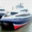

In [27]:
print('prediction',pre, 'gt',y, tedt.classes[y])
xpil

prediction 0 gt tensor([8]) ship


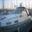

In [29]:
print('prediction',pre, 'gt',y, tedt.classes[y])
xpil

prediction 8 gt tensor([0]) airplane


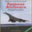

In [31]:
print('prediction',pre, 'gt',y, tedt.classes[y])
xpil

prediction 6 gt tensor([6]) frog


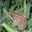

In [33]:
print('prediction',pre, 'gt',y, tedt.classes[y])
xpil

prediction 6 gt tensor([6]) frog


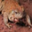

In [36]:
print('prediction',pre, 'gt',y, tedt.classes[y])
xpil